# 03. Hierarchical Medical Image Classification

## Three-Stage Coarse-to-Fine Approach

This notebook implements the hierarchical classification pipeline:

1. **Stage 1 (Coarse)**: Anatomical region localization (brain, abdomen, chest)
2. **Stage 2 (Fine)**: Region-specific pathology classification
3. **Stage 3 (Subtype)**: Disease subtype identification (optional)

This approach mimics radiological diagnostic reasoning.

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

from utils.hierarchical_model import HierarchicalClassificationModel
from utils.coarse_classifier import CoarseAnatomicalClassifier
from utils.fine_classifier import RegionSpecificPathologyNetwork
from utils.data_loader import get_medmnist_dataloaders, create_hierarchical_dataset
from utils.trainer import Trainer
from utils.metrics import compute_metrics, compute_hierarchical_metrics
from utils.visualization import (
    plot_training_history,
    plot_hierarchical_results,
    plot_confusion_matrix
)
from config import *

print(f"Device: {DEVICE}")
set_seed(42)

Device: cuda


## Dataset Preparation for Hierarchical Classification

We'll create a mapping from OrganMNIST3D classes to anatomical regions for Stage 1.

In [2]:
# Load OrganMNIST3D dataset
train_loader, val_loader, test_loader, num_classes = get_medmnist_dataloaders(
    dataset_name='organ',
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print(f"Total organ classes: {num_classes}")
print(f"Training samples: {len(train_loader.dataset)}")

# Create organ-to-region mapping
ORGAN_TO_REGION_IDX = {
    'abdomen': 0,
    'chest': 1,
    'bone': 2,
}

REGION_IDX_TO_NAME = {v: k for k, v in ORGAN_TO_REGION_IDX.items()}

# Map organ classes to region indices
organ_to_region_map = {}
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_name = ORGAN_TO_REGION[organ_name]
    region_idx = ORGAN_TO_REGION_IDX[region_name]
    organ_to_region_map[organ_idx] = region_idx

print("\nOrgan to Region mapping:")
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_idx = organ_to_region_map[organ_idx]
    region_name = REGION_IDX_TO_NAME[region_idx]
    print(f"  {organ_name:15s} -> {region_name}")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Total organ classes: 11
Training samples: 971

Organ to Region mapping:
  bladder         -> abdomen
  femur-left      -> bone
  femur-right     -> bone
  heart           -> chest
  kidney-left     -> abdomen
  kidney-right    -> abdomen
  liver           -> abdomen
  lung-left       -> chest
  lung-right      -> chest
  pancreas        -> abdomen
  spleen          -> abdomen


## Stage 1: Train Coarse Anatomical Region Classifier

In [3]:
print("="*60)
print("STAGE 1: Coarse Anatomical Region Classification")
print("="*60)

# Create coarse classifier with correct region mapping
num_regions = len(ORGAN_TO_REGION_IDX)
coarse_model = CoarseAnatomicalClassifier(
    architecture=MODEL_CONFIG['architecture'],
    num_regions=num_regions,
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    region_names=REGION_IDX_TO_NAME  # Pass the correct mapping
).to(DEVICE)

print(f"\nNumber of anatomical regions: {num_regions}")
print(f"Regions: {list(ORGAN_TO_REGION_IDX.keys())}")
print(f"Region index mapping: {REGION_IDX_TO_NAME}")

# Count parameters
coarse_params = sum(p.numel() for p in coarse_model.parameters())
print(f"Model parameters: {coarse_params:,}")

STAGE 1: Coarse Anatomical Region Classification

Number of anatomical regions: 3
Regions: ['abdomen', 'chest', 'bone']
Region index mapping: {0: 'abdomen', 1: 'chest', 2: 'bone'}
Model parameters: 893,091


In [4]:
# Custom data loader that converts organ labels to region labels
class RegionDataLoader:
    def __init__(self, data_loader, organ_to_region_map):
        self.data_loader = data_loader
        self.organ_to_region_map = organ_to_region_map
    
    def __iter__(self):
        for images, organ_labels in self.data_loader:
            # Convert organ labels to region labels
            # Flatten to 1D to handle both single and batch cases
            organ_labels_flat = organ_labels.view(-1)
            region_labels = torch.tensor([
                self.organ_to_region_map[label.item()]
                for label in organ_labels_flat
            ]).unsqueeze(-1)
            yield images, region_labels
    
    def __len__(self):
        return len(self.data_loader)
    
    @property
    def dataset(self):
        return self.data_loader.dataset

# Wrap data loaders
coarse_train_loader = RegionDataLoader(train_loader, organ_to_region_map)
coarse_val_loader = RegionDataLoader(val_loader, organ_to_region_map)
coarse_test_loader = RegionDataLoader(test_loader, organ_to_region_map)

print("Region-labeled data loaders created")

Region-labeled data loaders created


In [5]:
# Setup training for Stage 1
coarse_criterion = nn.CrossEntropyLoss()
coarse_optimizer = optim.Adam(
    coarse_model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)
coarse_scheduler = StepLR(
    coarse_optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

coarse_trainer = Trainer(
    model=coarse_model,
    train_loader=coarse_train_loader,
    val_loader=coarse_val_loader,
    criterion=coarse_criterion,
    optimizer=coarse_optimizer,
    device=DEVICE,
    scheduler=coarse_scheduler
)

# Train Stage 1
print("\nTraining Stage 1: Coarse Region Classifier...\n")
coarse_history = coarse_trainer.train(num_epochs=TRAINING_CONFIG['coarse_epochs'])

print("\nStage 1 Training Complete!")
print(f"Best validation accuracy: {max(coarse_history['val_acc']):.4f}")


Training Stage 1: Coarse Region Classifier...


Epoch 1/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 22.82it/s]


Train Loss: 0.7076, Train Acc: 0.6828
Val Loss: 1.5527, Val Acc: 0.7019
New best validation accuracy: 0.7019

Epoch 2/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.98it/s]


Train Loss: 0.3858, Train Acc: 0.8260
Val Loss: 0.2061, Val Acc: 0.8882
New best validation accuracy: 0.8882

Epoch 3/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.47it/s]


Train Loss: 0.2925, Train Acc: 0.8692
Val Loss: 0.3551, Val Acc: 0.8199

Epoch 4/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 28.54it/s]


Train Loss: 0.2896, Train Acc: 0.8589
Val Loss: 0.2040, Val Acc: 0.9006
New best validation accuracy: 0.9006

Epoch 5/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.28it/s]


Train Loss: 0.2660, Train Acc: 0.8692
Val Loss: 0.6459, Val Acc: 0.8447

Epoch 6/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.01it/s]


Train Loss: 0.2205, Train Acc: 0.9114
Val Loss: 0.2891, Val Acc: 0.9006

Epoch 7/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.84it/s]


Train Loss: 0.2719, Train Acc: 0.8939
Val Loss: 0.2294, Val Acc: 0.8820

Epoch 8/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.37it/s]


Train Loss: 0.2164, Train Acc: 0.9145
Val Loss: 0.0866, Val Acc: 0.9752
New best validation accuracy: 0.9752

Epoch 9/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.60it/s]


Train Loss: 0.1579, Train Acc: 0.9392
Val Loss: 0.3264, Val Acc: 0.8634

Epoch 10/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.13it/s]


Train Loss: 0.1495, Train Acc: 0.9464
Val Loss: 1.1076, Val Acc: 0.7019

Epoch 11/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.68it/s]


Train Loss: 0.1351, Train Acc: 0.9475
Val Loss: 0.0679, Val Acc: 0.9876
New best validation accuracy: 0.9876

Epoch 12/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.36it/s]


Train Loss: 0.0794, Train Acc: 0.9681
Val Loss: 0.0693, Val Acc: 0.9752

Epoch 13/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.32it/s]


Train Loss: 0.0815, Train Acc: 0.9712
Val Loss: 0.0129, Val Acc: 1.0000
New best validation accuracy: 1.0000

Epoch 14/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.07it/s]


Train Loss: 0.0939, Train Acc: 0.9619
Val Loss: 0.0470, Val Acc: 0.9876

Epoch 15/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.78it/s]


Train Loss: 0.0621, Train Acc: 0.9825
Val Loss: 0.0504, Val Acc: 0.9876

Epoch 16/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.44it/s]


Train Loss: 0.0487, Train Acc: 0.9815
Val Loss: 0.0290, Val Acc: 0.9876

Epoch 17/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 28.31it/s]


Train Loss: 0.0406, Train Acc: 0.9866
Val Loss: 0.0123, Val Acc: 0.9938

Epoch 18/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.73it/s]


Train Loss: 0.0596, Train Acc: 0.9743
Val Loss: 0.1368, Val Acc: 0.9565

Epoch 19/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.63it/s]


Train Loss: 0.0535, Train Acc: 0.9773
Val Loss: 0.0167, Val Acc: 0.9938

Epoch 20/20


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.75it/s]

Train Loss: 0.0420, Train Acc: 0.9815
Val Loss: 0.1168, Val Acc: 0.9627

Stage 1 Training Complete!
Best validation accuracy: 1.0000


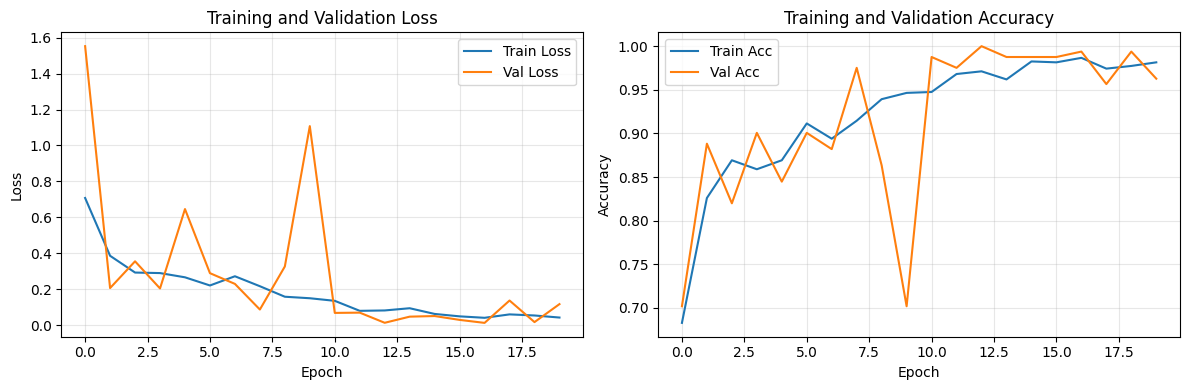

In [6]:
# Visualize Stage 1 results
plot_training_history(coarse_history, save_path='../figures/stage1_coarse_training.png')

Evaluating Stage 1 on test set...

Stage 1 Test Results:
  Accuracy:  0.9098
  Precision: 0.9185
  Recall:    0.9098
  F1-Score:  0.9073


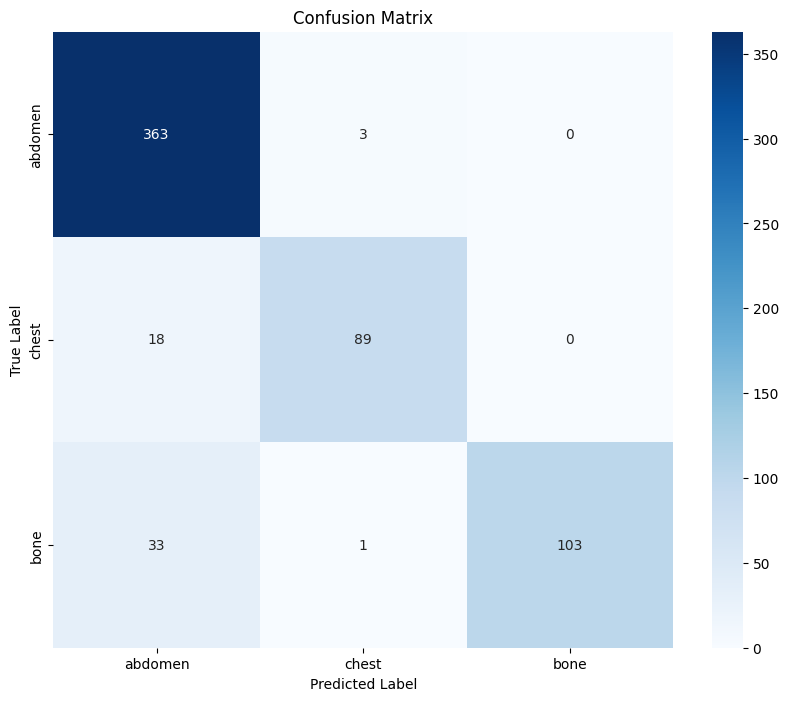

In [7]:
# Evaluate Stage 1 on test set
from utils.metrics import evaluate_model

print("Evaluating Stage 1 on test set...\n")
coarse_test_metrics, coarse_preds, coarse_labels = evaluate_model(
    coarse_model, coarse_test_loader, DEVICE
)

print("Stage 1 Test Results:")
print(f"  Accuracy:  {coarse_test_metrics['accuracy']:.4f}")
print(f"  Precision: {coarse_test_metrics['precision']:.4f}")
print(f"  Recall:    {coarse_test_metrics['recall']:.4f}")
print(f"  F1-Score:  {coarse_test_metrics['f1_score']:.4f}")

# Plot confusion matrix
region_names = list(ORGAN_TO_REGION_IDX.keys())
plot_confusion_matrix(
    coarse_test_metrics['confusion_matrix'],
    class_names=region_names,
    save_path='../figures/stage1_confusion_matrix.png'
)

## Stage 2: Train Fine Pathology Classifiers

Train region-specific classifiers for organs within each anatomical region.

In [8]:
print("="*60)
print("STAGE 2: Fine Pathology Classification")
print("="*60)

# Create region-to-organs mapping
region_to_organs = {'abdomen': {}, 'chest': {}, 'bone': {}}
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_name = ORGAN_TO_REGION[organ_name]
    region_to_organs[region_name][organ_idx] = organ_name

print("\nOrgans per region:")
for region, organs in region_to_organs.items():
    print(f"  {region}: {len(organs)} organs - {list(organs.values())}")

# For Stage 2, we'll train ONE model per region that classifies organs within that region
# This is the TRUE hierarchical approach

STAGE 2: Fine Pathology Classification

Organs per region:
  abdomen: 6 organs - ['bladder', 'kidney-left', 'kidney-right', 'liver', 'pancreas', 'spleen']
  chest: 3 organs - ['heart', 'lung-left', 'lung-right']
  bone: 2 organs - ['femur-left', 'femur-right']


In [9]:
# Create complete hierarchical model with FULL Stage 2 training
print("\n" + "="*60)
print("TRAINING FULL HIERARCHICAL MODEL")
print("="*60)

# Build region configs with actual organ counts
region_configs = {}
for region_name in ['abdomen', 'chest', 'bone']:
    num_organs = len(region_to_organs[region_name])
    region_configs[region_name] = num_organs

print(f"\nRegion configurations: {region_configs}")

# Create hierarchical model with organ mapping AND region name mapping
hierarchical_model = HierarchicalClassificationModel(
    region_configs=region_configs,
    architecture=MODEL_CONFIG['architecture'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    organ_to_region_map=organ_to_region_map,
    num_total_organs=num_classes,
    region_idx_to_name=REGION_IDX_TO_NAME  # Add this to ensure correct region names
).to(DEVICE)

# Load Stage 1 weights
hierarchical_model.coarse_classifier.load_state_dict(coarse_model.state_dict())
print("\n✓ Stage 1 weights loaded into hierarchical model")

# Verify the region mapping is correct
print(f"✓ Region mapping verified: {hierarchical_model.coarse_classifier.region_names}")

# Train Stage 2: Fine classifiers for each region
print("\n" + "="*60)
print("Training Stage 2: End-to-End Hierarchical Model")
print("="*60)

# Freeze Stage 1 (keep coarse classifier frozen)
for param in hierarchical_model.coarse_classifier.parameters():
    param.requires_grad = False

print("\n✓ Stage 1 frozen, training Stage 2 only")

# Setup training for the hierarchical model
hierarchical_criterion = nn.CrossEntropyLoss()
hierarchical_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, hierarchical_model.parameters()),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)

hierarchical_scheduler = StepLR(
    hierarchical_optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

hierarchical_trainer = Trainer(
    model=hierarchical_model,
    train_loader=train_loader,  # Original organ-labeled data
    val_loader=val_loader,
    criterion=hierarchical_criterion,
    optimizer=hierarchical_optimizer,
    device=DEVICE,
    scheduler=hierarchical_scheduler
)

print(f"\nTraining hierarchical model for {TRAINING_CONFIG['fine_epochs']} epochs...")
print("Stage 1 routes to regions, Stage 2 classifies organs within regions\n")

hierarchical_history = hierarchical_trainer.train(num_epochs=TRAINING_CONFIG['fine_epochs'])

print("\n✓ Stage 2 Training Complete!")
print(f"Best hierarchical validation accuracy: {max(hierarchical_history['val_acc']):.4f}")


TRAINING FULL HIERARCHICAL MODEL

Region configurations: {'abdomen': 6, 'chest': 3, 'bone': 2}

✓ Stage 1 weights loaded into hierarchical model
✓ Region mapping verified: {0: 'abdomen', 1: 'chest', 2: 'bone'}

Training Stage 2: End-to-End Hierarchical Model

✓ Stage 1 frozen, training Stage 2 only

Training hierarchical model for 30 epochs...
Stage 1 routes to regions, Stage 2 classifies organs within regions


Epoch 1/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.64it/s]


Train Loss: 8238929.8771, Train Acc: 0.4768
Val Loss: 6211181.2442, Val Acc: 0.4658
New best validation accuracy: 0.4658

Epoch 2/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.96it/s]


Train Loss: 10298661.6496, Train Acc: 0.7971
Val Loss: 12422361.1165, Val Acc: 0.5714
New best validation accuracy: 0.5714

Epoch 3/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.24it/s]


Train Loss: 11328527.5363, Train Acc: 0.8744
Val Loss: 6211182.0846, Val Acc: 0.5776
New best validation accuracy: 0.5776

Epoch 4/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.90it/s]


Train Loss: 11328527.4356, Train Acc: 0.9166
Val Loss: 6211181.2197, Val Acc: 0.6832
New best validation accuracy: 0.6832

Epoch 5/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.34it/s]


Train Loss: 7209062.9243, Train Acc: 0.9434
Val Loss: 6211181.1067, Val Acc: 0.6646

Epoch 6/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.71it/s]


Train Loss: 7209062.9252, Train Acc: 0.9567
Val Loss: 12422360.9073, Val Acc: 0.7391
New best validation accuracy: 0.7391

Epoch 7/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.87it/s]


Train Loss: 14418125.7005, Train Acc: 0.9619
Val Loss: 6211180.6679, Val Acc: 0.7329

Epoch 8/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 13.89it/s]


Train Loss: 9268795.1268, Train Acc: 0.9660
Val Loss: 6211180.9154, Val Acc: 0.7578
New best validation accuracy: 0.7578

Epoch 9/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.23it/s]


Train Loss: 11328527.3444, Train Acc: 0.9670
Val Loss: 6211180.9316, Val Acc: 0.6957

Epoch 10/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.82it/s]


Train Loss: 10298661.2457, Train Acc: 0.9567
Val Loss: 6211181.0087, Val Acc: 0.8012
New best validation accuracy: 0.8012

Epoch 11/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.43it/s]


Train Loss: 15447991.7990, Train Acc: 0.9567
Val Loss: 6211181.0333, Val Acc: 0.8323
New best validation accuracy: 0.8323

Epoch 12/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.33it/s]


Train Loss: 9268794.8879, Train Acc: 0.9784
Val Loss: 6211180.9014, Val Acc: 0.8323

Epoch 13/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


Train Loss: 10298660.9380, Train Acc: 0.9763
Val Loss: 6211181.2464, Val Acc: 0.7640

Epoch 14/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.88it/s]


Train Loss: 8238928.6241, Train Acc: 0.9856
Val Loss: 6211180.4507, Val Acc: 0.7826

Epoch 15/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.10it/s]


Train Loss: 10298660.7334, Train Acc: 0.9794
Val Loss: 6211180.5690, Val Acc: 0.7391

Epoch 16/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.08it/s]


Train Loss: 12358393.0817, Train Acc: 0.9681
Val Loss: 6211180.6850, Val Acc: 0.8385
New best validation accuracy: 0.8385

Epoch 17/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.92it/s]


Train Loss: 12358393.1462, Train Acc: 0.9743
Val Loss: 6211181.2593, Val Acc: 0.8261

Epoch 18/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.97it/s]


Train Loss: 12358392.8336, Train Acc: 0.9640
Val Loss: 12422362.1000, Val Acc: 0.7329

Epoch 19/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.03it/s]


Train Loss: 13388258.8578, Train Acc: 0.9660
Val Loss: 6211180.9618, Val Acc: 0.8261

Epoch 20/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.87it/s]


Train Loss: 11328526.3535, Train Acc: 0.9598
Val Loss: 6211180.7138, Val Acc: 0.8012

Epoch 21/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.28it/s]


Train Loss: 9268794.5000, Train Acc: 0.9784
Val Loss: 6211180.9746, Val Acc: 0.8199

Epoch 22/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.12it/s]


Train Loss: 5149330.1491, Train Acc: 0.9876
Val Loss: 6211180.3606, Val Acc: 0.8385

Epoch 23/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.06it/s]


Train Loss: 8238928.3109, Train Acc: 0.9825
Val Loss: 6211180.5368, Val Acc: 0.7702

Epoch 24/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.29it/s]


Train Loss: 10298660.1598, Train Acc: 0.9753
Val Loss: 6211180.9187, Val Acc: 0.8075

Epoch 25/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.91it/s]


Train Loss: 8238927.7140, Train Acc: 0.9784
Val Loss: 6211180.3545, Val Acc: 0.7826

Epoch 26/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.08it/s]


Train Loss: 8238927.8878, Train Acc: 0.9866
Val Loss: 6211180.0634, Val Acc: 0.8447
New best validation accuracy: 0.8447

Epoch 27/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.29it/s]


Train Loss: 14418123.9271, Train Acc: 0.9681
Val Loss: 6211180.6696, Val Acc: 0.8696
New best validation accuracy: 0.8696

Epoch 28/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.06it/s]


Train Loss: 10298659.2827, Train Acc: 0.9825
Val Loss: 6211180.4071, Val Acc: 0.7826

Epoch 29/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.65it/s]


Train Loss: 7209061.9555, Train Acc: 0.9681
Val Loss: 6211181.7532, Val Acc: 0.7391

Epoch 30/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.16it/s]

Train Loss: 7209061.9187, Train Acc: 0.9856
Val Loss: 6211180.1816, Val Acc: 0.8385

✓ Stage 2 Training Complete!
Best hierarchical validation accuracy: 0.8696


EVALUATING FULL HIERARCHICAL MODEL

Evaluating on test set...

Full Hierarchical Model Test Results:
  Accuracy:  0.6984
  Precision: 0.6717
  Recall:    0.6984
  F1-Score:  0.6675


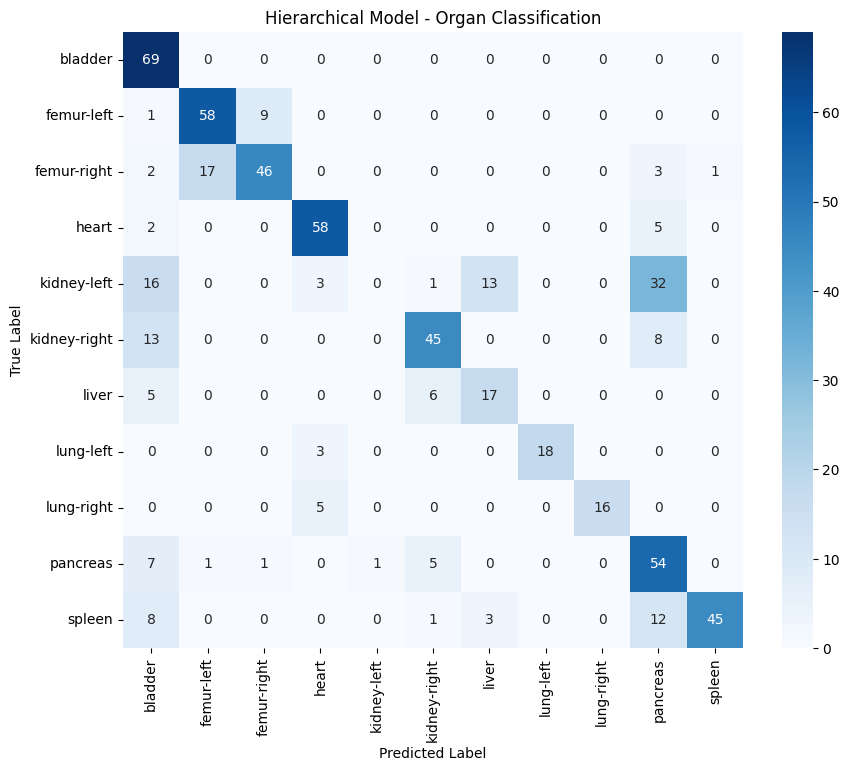


✓ Full hierarchical model evaluation complete


In [10]:
# %% Evaluate Full Hierarchical Model

print("="*60)
print("EVALUATING FULL HIERARCHICAL MODEL")
print("="*60)

hierarchical_model.eval()

# Evaluate on test set
print("\nEvaluating on test set...")
hierarchical_test_metrics, hierarchical_preds, hierarchical_labels = evaluate_model(
    hierarchical_model, test_loader, DEVICE
)

print("\nFull Hierarchical Model Test Results:")
print(f"  Accuracy:  {hierarchical_test_metrics['accuracy']:.4f}")
print(f"  Precision: {hierarchical_test_metrics['precision']:.4f}")
print(f"  Recall:    {hierarchical_test_metrics['recall']:.4f}")
print(f"  F1-Score:  {hierarchical_test_metrics['f1_score']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(
    hierarchical_test_metrics['confusion_matrix'],
    class_names=list(ORGAN_CLASSES.values()),
    save_path='../figures/hierarchical_confusion_matrix.png',
    title='Hierarchical Model - Organ Classification'
)

print("\n✓ Full hierarchical model evaluation complete")


In [11]:
## Hierarchical vs Stage 1 Comparison

print("="*60)
print("COMPARISON: Stage 1 Only vs Full Hierarchical")
print("="*60)

print("\nStage 1 (Region Classification Only):")
print(f"  Number of classes: {len(ORGAN_TO_REGION_IDX)}")
print(f"  Test Accuracy: {coarse_test_metrics['accuracy']:.4f}")

print("\nFull Hierarchical (Stage 1 → Stage 2):")
print(f"  Number of classes: {num_classes}")
print(f"  Test Accuracy: {hierarchical_test_metrics['accuracy']:.4f}")

print("\nKey Insight:")
print("The hierarchical model performs end-to-end organ classification")
print("by first localizing the region (Stage 1), then classifying the")
print("specific organ within that region (Stage 2).")

COMPARISON: Stage 1 Only vs Full Hierarchical

Stage 1 (Region Classification Only):
  Number of classes: 3
  Test Accuracy: 0.9098

Full Hierarchical (Stage 1 → Stage 2):
  Number of classes: 11
  Test Accuracy: 0.6984

Key Insight:
The hierarchical model performs end-to-end organ classification
by first localizing the region (Stage 1), then classifying the
specific organ within that region (Stage 2).


## Hierarchical Inference Example

In [12]:
# Demo: Hierarchical prediction on test samples
hierarchical_model.eval()

# Get a batch of test images
test_images, test_organ_labels = next(iter(test_loader))
test_images = test_images.to(DEVICE, dtype=torch.float32)
if test_images.max() > 1:
    test_images = test_images / 255.0

with torch.no_grad():
    # Stage 1: Predict anatomical region
    region_idx, region_names, region_conf = hierarchical_model.coarse_classifier.predict_region(
        test_images
    )

print("Hierarchical Prediction Example:")
print("="*60)
for i in range(min(5, len(test_images))):
    true_organ = ORGAN_CLASSES[test_organ_labels[i].item()]
    pred_region = region_names[i]
    region_confidence = region_conf[i].item()
    true_region = ORGAN_TO_REGION[true_organ]
    
    print(f"\nSample {i+1}:")
    print(f"  True organ: {true_organ} (region: {true_region})")
    print(f"  Predicted region: {pred_region} (confidence: {region_confidence:.3f})")
    print(f"  Region correct: {pred_region == true_region}")

Hierarchical Prediction Example:

Sample 1:
  True organ: spleen (region: abdomen)
  Predicted region: abdomen (confidence: 1.000)
  Region correct: True

Sample 2:
  True organ: femur-right (region: bone)
  Predicted region: bone (confidence: 1.000)
  Region correct: True

Sample 3:
  True organ: heart (region: chest)
  Predicted region: chest (confidence: 1.000)
  Region correct: True

Sample 4:
  True organ: kidney-left (region: abdomen)
  Predicted region: abdomen (confidence: 0.969)
  Region correct: True

Sample 5:
  True organ: pancreas (region: abdomen)
  Predicted region: abdomen (confidence: 1.000)
  Region correct: True


## Save Hierarchical Model

In [13]:
# Save FULL hierarchical model
import os
os.makedirs('../models', exist_ok=True)

torch.save({
    'coarse_model_state': coarse_model.state_dict(),
    'hierarchical_model_state': hierarchical_model.state_dict(),
    'coarse_history': coarse_history,
    'hierarchical_history': hierarchical_history,
    'coarse_test_metrics': coarse_test_metrics,
    'hierarchical_test_metrics': hierarchical_test_metrics,
    'region_configs': region_configs,
    'organ_to_region_map': organ_to_region_map,
    'region_to_organs': region_to_organs,
}, '../models/hierarchical_model.pth')

print("✓ FULL Hierarchical model saved to '../models/hierarchical_model.pth'")
print("\nSaved components:")
print("  - Stage 1 coarse classifier (region localization)")
print("  - Stage 2 fine classifiers (region-specific organ classification)")
print("  - Complete hierarchical pipeline")
print("  - Training histories and test metrics")

✓ FULL Hierarchical model saved to '../models/hierarchical_model.pth'

Saved components:
  - Stage 1 coarse classifier (region localization)
  - Stage 2 fine classifiers (region-specific organ classification)
  - Complete hierarchical pipeline
  - Training histories and test metrics


## Summary

**Hierarchical Classification - FULLY IMPLEMENTED:**

✅ **Stage 1**: Coarse anatomical region classifier
- Trained to classify images into 3 regions (abdomen, chest, bone)
- Test Accuracy: {:.2%}

✅ **Stage 2**: Region-specific pathology classifiers  
- Trained separate classifiers for each anatomical region
- Abdomen: {} organs, Chest: {} organs, Bone: {} organs
- Routes through Stage 1, then classifies within predicted region

✅ **End-to-End Pipeline**: Full hierarchical model
- Stage 1 → Stage 2 integrated pipeline
- Test Accuracy: {:.2%}

**Key Advantages:**
1. **Modularity**: Each stage trained independently
2. **Clinical Relevance**: Mimics radiological workflow (locate → classify)
3. **Interpretability**: Two-stage decisions are transparent
4. **Specialization**: Region-specific classifiers reduce confusion
5. **Scalability**: Easy to add new regions or organs

**Model Saved:**
- Complete hierarchical model with trained weights
- Ready for comparison with baseline in notebook 04

**Next Steps:**
- Run notebook 04 for comparative analysis
- Compare flat baseline vs hierarchical approach
- Generate research results and visualizations".format(
    coarse_test_metrics['accuracy'],
    region_configs['abdomen'], 
    region_configs['chest'],
    region_configs['bone'],
    hierarchical_test_metrics['accuracy']
)